In [ ]:
!pip install scikeras[tensorflow]
!pip install scikit-optimize
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
df = pd.read_csv("/content/data.csv")

In [ ]:
df = df.drop(columns=['id', 'Unnamed: 32'], errors='ignore')

In [ ]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
df.diagnosis.replace({'M' : '1','B': '0'},inplace=True)

<ipython-input-6-f4635da07fa5>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.diagnosis.replace({'M' : '1','B': '0'},inplace=True)


In [ ]:
df.diagnosis = df.diagnosis.astype('float64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    float64
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [ ]:
df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])

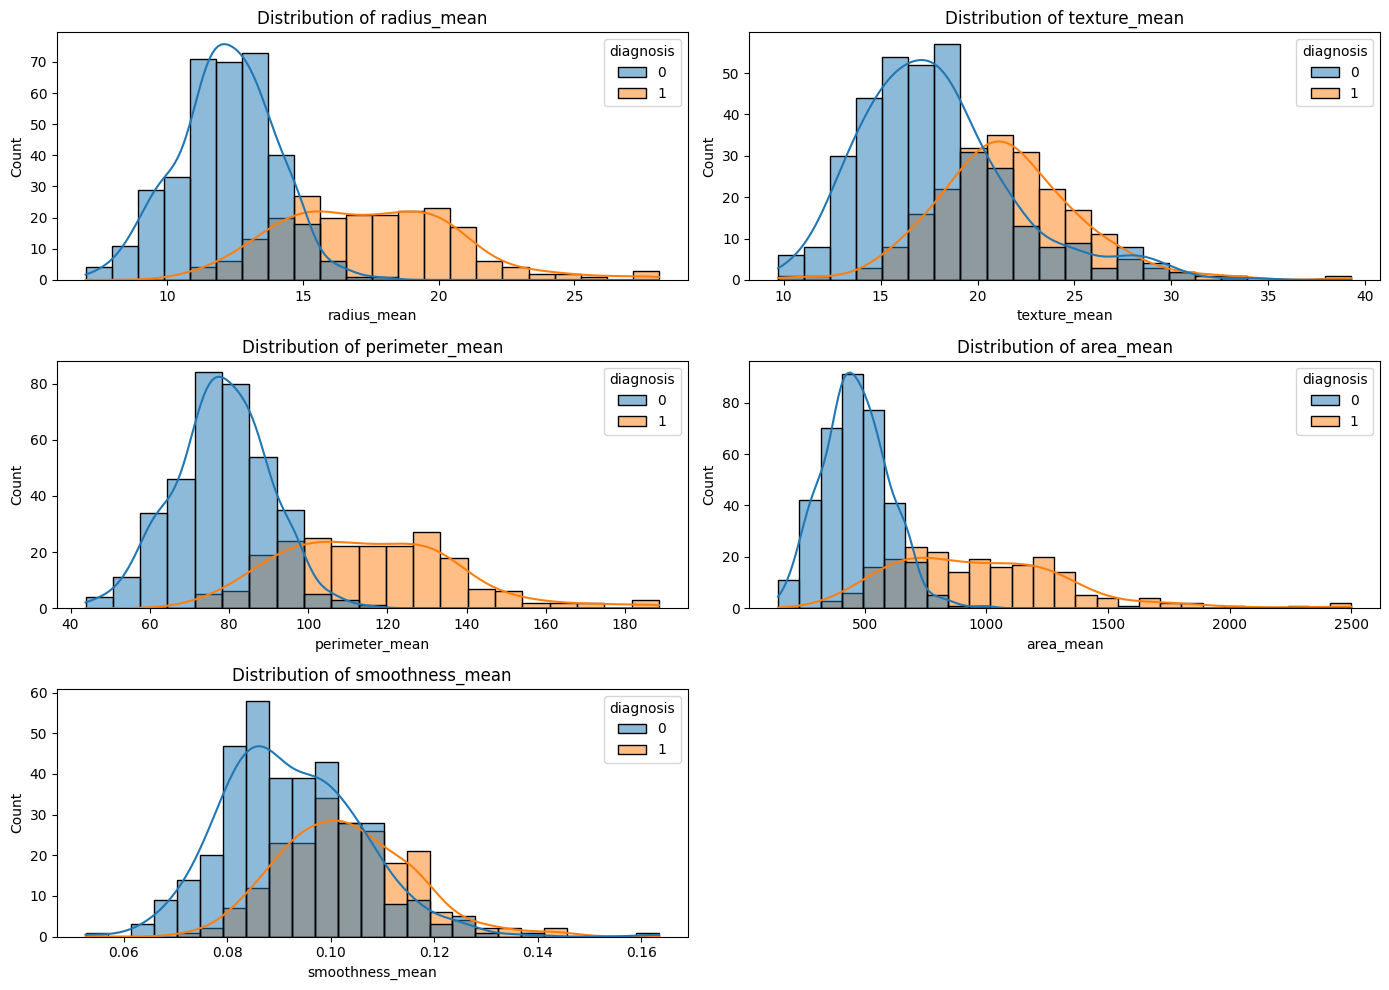

In [ ]:
features_to_plot = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=df, x=feature, hue='diagnosis', kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

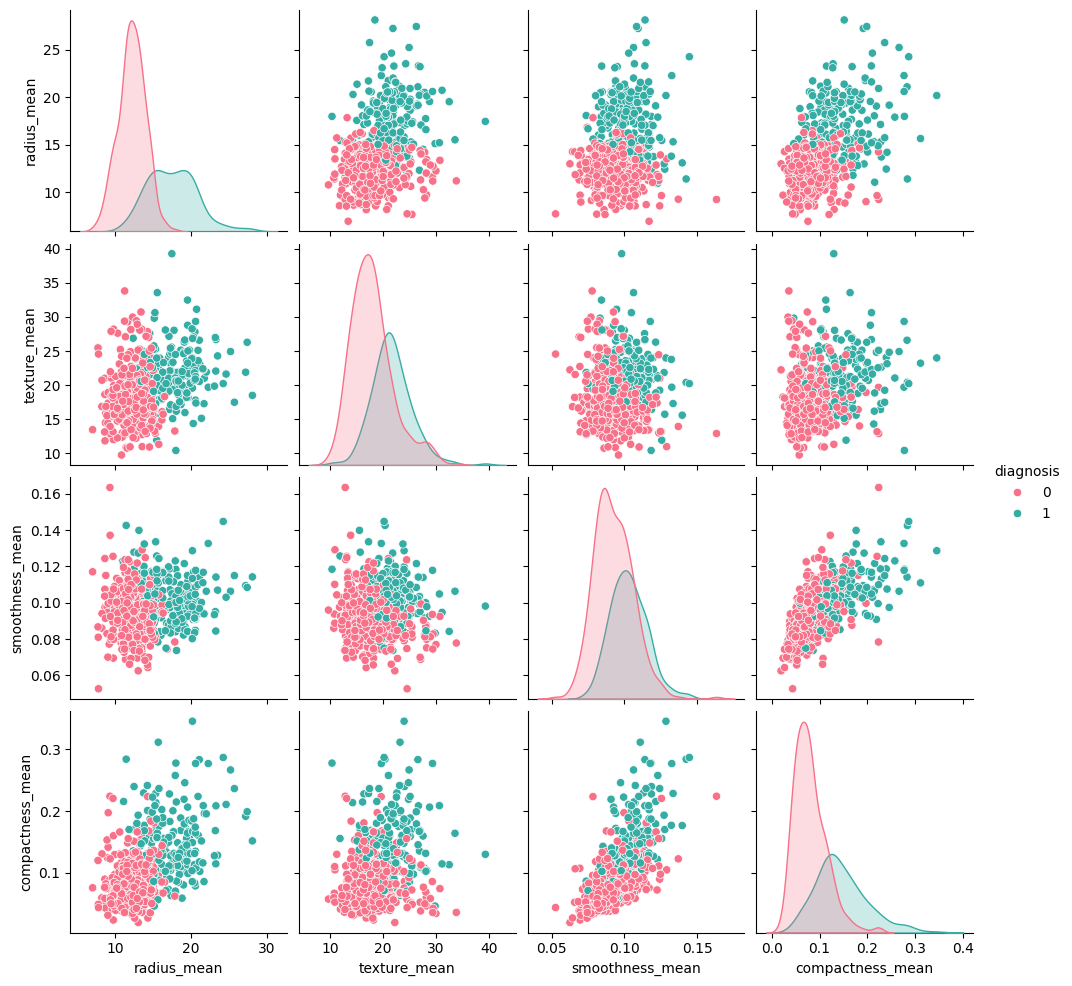

In [ ]:
subset_features = ['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'diagnosis']
sns.pairplot(df[subset_features], hue='diagnosis', palette="husl")
plt.show()

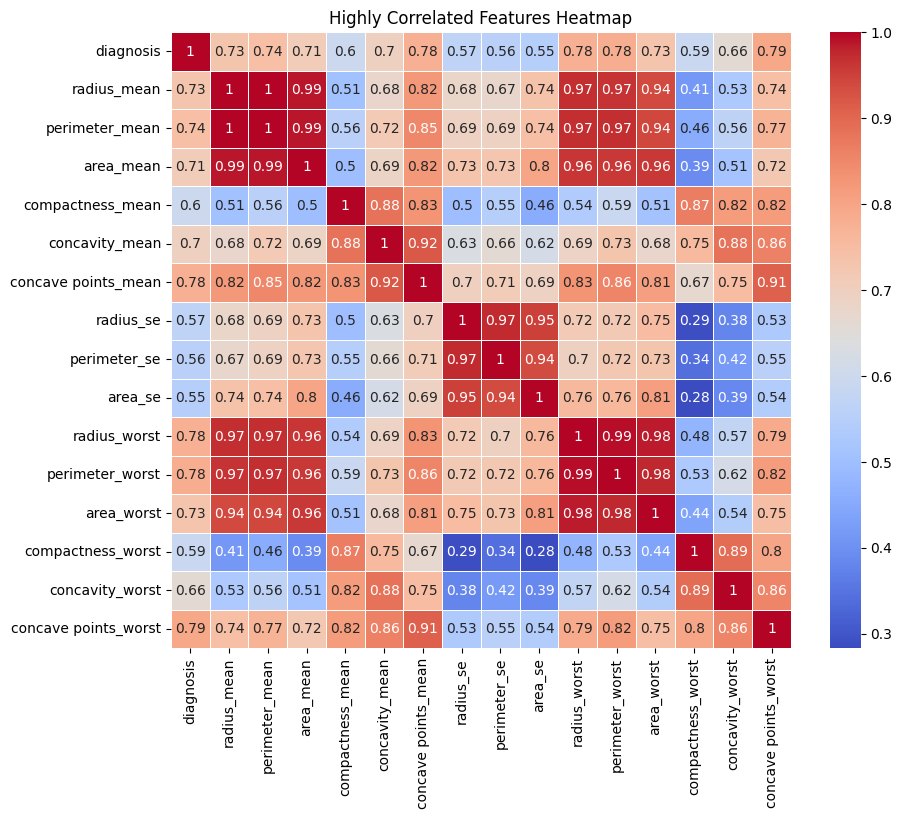

In [ ]:
correlation_matrix = df.corr()
high_corr_features = correlation_matrix.index[abs(correlation_matrix["diagnosis"]) > 0.5]

plt.figure(figsize=(10, 8))
sns.heatmap(df[high_corr_features].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Highly Correlated Features Heatmap")
plt.show()

<ipython-input-13-47a1fbb32aae>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=feature, data=df, palette="Set2")
<ipython-input-13-47a1fbb32aae>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=feature, data=df, palette="Set2")
<ipython-input-13-47a1fbb32aae>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=feature, data=df, palette="Set2")
<ipython-input-13-47a1fbb32aae>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

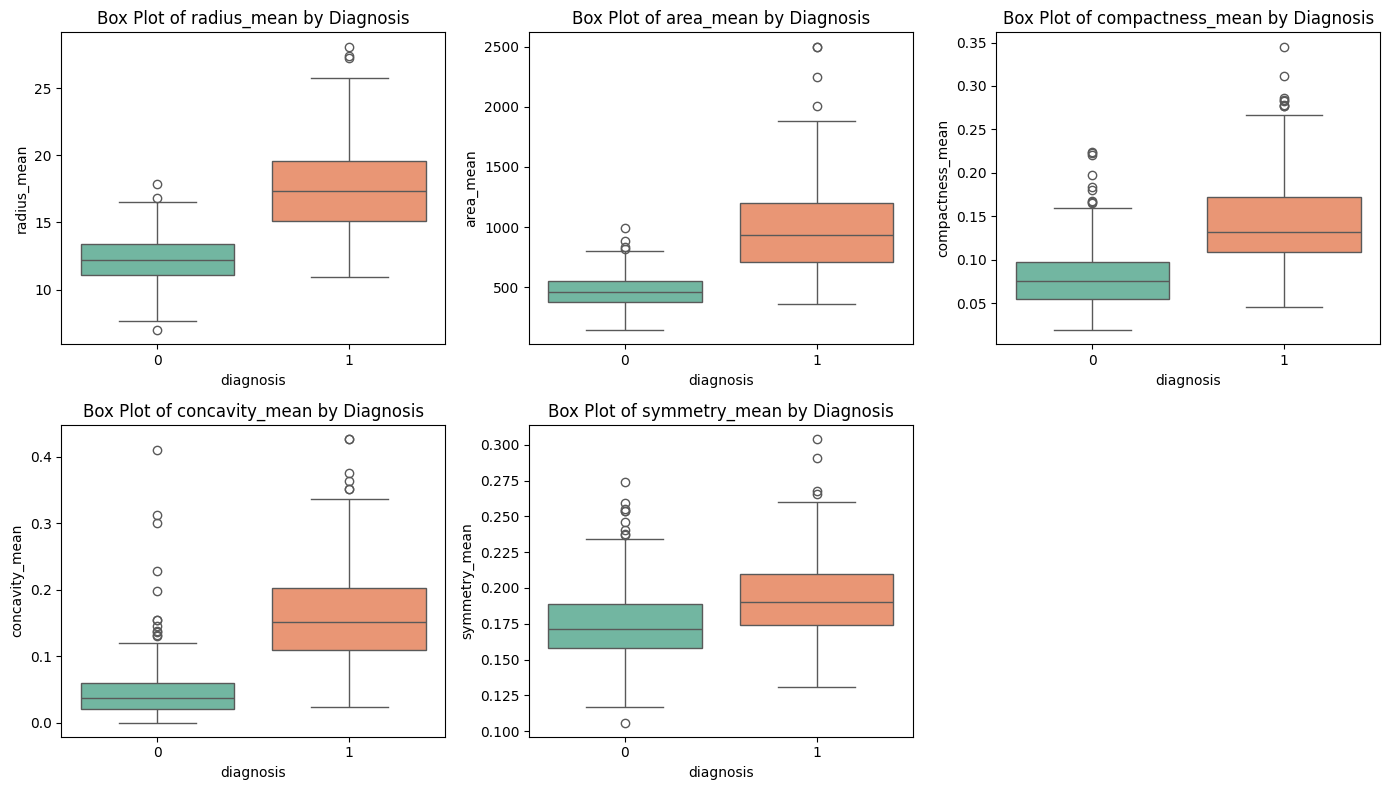

In [ ]:
features_to_plot = ['radius_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'symmetry_mean']
plt.figure(figsize=(14, 8))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='diagnosis', y=feature, data=df, palette="Set2")
    plt.title(f'Box Plot of {feature} by Diagnosis')
plt.tight_layout()
plt.show()

In [ ]:
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, hidden_units=32, dropout_rate=0.2, learning_rate=0.001, **fit_params):
        self.build_fn = build_fn
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.fit_params = fit_params
        self.model = None

    def fit(self, X, y, **fit_params):
        # Pass the hyperparameters to the model-building function
        self.model = self.build_fn(hidden_units=self.hidden_units,
                                   dropout_rate=self.dropout_rate,
                                   learning_rate=self.learning_rate)
        self.model.fit(X, y, **fit_params)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int).flatten()

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]  # Returns accuracy


In [ ]:
def create_model(hidden_units=32, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        Dense(hidden_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(hidden_units // 2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
param_grid = {
    'hidden_units': (16, 128),           # Range of hidden units
    'dropout_rate': (0.0, 0.5, 'uniform'),  # Dropout rate between 0 and 0.5
    'learning_rate': (1e-4, 1e-2, 'log-uniform')  # Learning rate between 1e-4 and 1e-2
}

In [ ]:
model = CustomKerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

In [ ]:
search = BayesSearchCV(estimator=model, search_spaces=param_grid, n_iter=10, cv=3, verbose=0)
search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.6492 - loss: 0.6002
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.7770 - loss: 0.4551
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.7308 - loss: 0.5676


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.5544 - loss: 0.8126
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.6311 - loss: 0.7831
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.5973 - loss: 0.6615


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.3825 - loss: 0.8362
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 0.3367 - loss: 0.8059
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.6772 - loss: 0.6339


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.4901 - loss: 0.6843
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.7089 - loss: 0.6539
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.7014 - loss: 0.6515


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.4303 - loss: 0.8929
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4250 - loss: 0.9165
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.5927 - loss: 0.6956


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.5065 - loss: 0.7188
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7271 - loss: 0.5917
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.5527 - loss: 0.7832


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.4368 - loss: 0.7393
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6216 - loss: 0.7020
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.7031 - loss: 0.5845


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.2902 - loss: 0.9058
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.3707 - loss: 0.7747
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.3298 - loss: 0.8606


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.4327 - loss: 0.7799
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.7359 - loss: 0.5519
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.5392 - loss: 0.7302


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.5623 - loss: 0.6549
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.6551 - loss: 0.6418
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.5808 - loss: 0.6677


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.8283 - loss: 0.4477


BayesSearchCV(cv=3,
              estimator=CustomKerasClassifier(build_fn=<function create_model at 0x7ce65a6d4b80>),
              n_iter=10,
              search_spaces={'dropout_rate': (0.0, 0.5, 'uniform'),
                             'hidden_units': (16, 128),
                             'learning_rate': (0.0001, 0.01, 'log-uniform')})

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
best_model = search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

# Calculate AUC ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print("AUC ROC:", auc_roc)

# Calculate Log Loss (loss)
loss = log_loss(y_test, y_pred_proba)
print("Log Loss:", loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.9736842105263158
F1-Score: 0.9647058823529412
AUC ROC: 0.9970520799213888
Log Loss: 0.0950987384873689


In [ ]:
print("Best Parameters:", search.best_params_)

Best Parameters: OrderedDict([('dropout_rate', 0.2638001020453262), ('hidden_units', 89), ('learning_rate', 0.0033141560730781594)])


In [ ]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred)

In [ ]:
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"MCC: {mcc}")

Sensitivity: 0.9534883720930233
Specificity: 0.9859154929577465
MCC: 0.9438975339262832


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

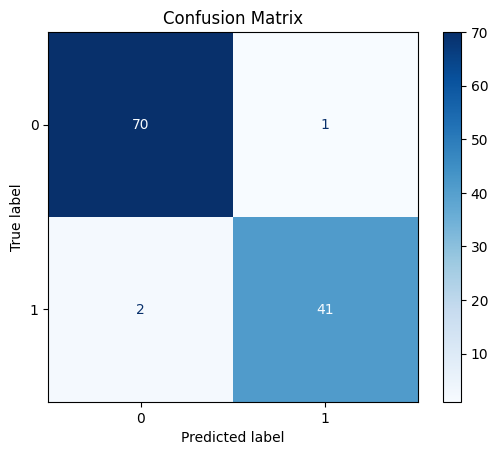

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
random_index = np.random.choice(len(y_test))
chosen_x = X_test[random_index]

chosen_x = chosen_x.reshape(1, -1)

prediction = best_model.predict(chosen_x)[0]

true_value = y_test.iloc[random_index]

print(f"Chosen X: {chosen_x}")
print(f"Predicted Value: {prediction}")
print(f"True Value: {true_value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Chosen X: [[-0.26830538 -0.22646371 -0.31291018 -0.33021186 -1.51599652 -0.83337113
  -0.50778391 -0.51501099 -1.30016283 -1.00902334 -0.70608498 -0.95663903
  -0.78410208 -0.49129178 -0.33407025 -0.57598608 -0.53514609 -0.54570359
  -1.18137349 -0.77169632 -0.27780059 -0.27163633 -0.36004356 -0.33398726
  -0.14451636 -0.36321625 -0.41590792 -0.14837686 -1.06214791 -0.81992483]]
Predicted Value: 0
True Value: 0
